## RMM2

In [1]:
!pwd

/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import hilbert_data1_jgrjd_20CRV3
import datetime
import matplotlib.pyplot as plt

In [3]:
def lowpass_scipy_butter(signal1,wn,lt):
    from scipy import signal
    w = 2/lt # Normalize the frequency
    b, a = signal.butter(wn, w, 'low')
    lowpass_signal = signal.filtfilt(b, a, signal1)

    return lowpass_signal


def data_y(st,en):

    df2       = pd.read_csv('full_data_nn_20CR_V3.txt',index_col='date')
    df2.index = pd.to_datetime(df2.index)
    df2=df2[(df2.index>=st) & (df2.index<=en)]    
    
    ################ RMM1 #########################
    y = df2.iloc[:,12:13]
    lf = 10;wn = 3
#    ### 10 days lowpass #############
    y1 = y.copy()
    for i in range(y.shape[1]):
        signal = y.iloc[:,i].values
        temp = lowpass_scipy_butter(signal,wn,lf)
        y1.iloc[:,i] = np.real(temp)
        
    RMM1 = y1.iloc[119:]
    del y,y1 

    ###################################    
    
     ################ RMM2 #########################
    y = df2.iloc[:,13:14]

#     ### 10 days lowpass #############
    y1 = y.copy()
    for i in range(y.shape[1]):
        signal = y.iloc[:,i].values
        temp = lowpass_scipy_butter(signal,wn,lf)
        y1.iloc[:,i] = np.real(temp)
    RMM2 = y1.iloc[119:]
    del y,y1 
#     ###################################    
       

    return RMM1,RMM2

In [4]:
df = xr.open_dataset('/home/cccr/roxy/panini/JGRJD_PHD_PART_I/JGRJD_DESKTOP/MJO_reconstruct_jgrjd/20CR_V3/CNN_maps_20CRV3/trop_sfc.ano_1905-2015_filtered_rm_mean120.4deg.nc')


In [5]:
_,y_train = data_y(datetime.datetime(1979,1,1),datetime.datetime(2008,12,31))
_,y_test = data_y(datetime.datetime(1974,6,1),datetime.datetime(1978,3,16))
_,y_test2 = data_y(datetime.datetime(2009,1,1),datetime.datetime(2015,12,31))

In [6]:
from sklearn.preprocessing import MinMaxScaler

sc3 = MinMaxScaler()

sc3.fit(y_train[:])

train_y = sc3.transform(y_train)
test_y  = sc3.transform(y_test)
test_y2  = sc3.transform(y_test2)

In [7]:
df_test3 = df.sel(lat=slice(-25,25))

In [8]:
from sklearn.preprocessing import MinMaxScaler
xtest3 = df_test3.pres_ano.values[:,:,:].copy()
scalers = {}
for i in range(xtest3.shape[0]):
    scalers = MinMaxScaler()
    num= df_test3.pres_ano.shape[1]*df_test3.pres_ano.shape[2]
    ff = xtest3[i,:,:].reshape(num,1)
    scalers.fit(ff)
    xtest3[i,:,:] = np.reshape(scalers.fit_transform(ff),(df_test3.pres_ano.shape[1],df_test3.pres_ano.shape[2]))

df_test3.pres_ano.values = xtest3

In [9]:
df_train = df_test3.sel(time=slice(str(y_train.index[0]),str(y_train.index[-1])),lat=slice(-25,25))
df_test = df_test3.sel(time=slice(str(y_test.index[0]),str(y_test.index[-1])),lat=slice(-25,25))
df_test2 = df_test3.sel(time=slice(str(y_test2.index[0]),str(y_test2.index[-1])),lat=slice(-25,25))

(array([  74591.,   44148.,   57687.,   77589.,  106691.,  148678.,
         212110.,  302398.,  425219.,  586347.,  794552., 1045029.,
        1344688., 1687650., 2052317., 2428715., 2790961., 3110623.,
        3338008., 3455591., 3460455., 3353842., 3147850., 2857038.,
        2503508., 2114656., 1704231., 1311135.,  962793.,  675383.,
         445767.,  279033.,  170266.,  107873.,  116318.]),
 array([0.        , 0.02857143, 0.05714286, 0.0857143 , 0.11428573,
        0.14285716, 0.17142859, 0.20000002, 0.22857146, 0.2571429 ,
        0.28571433, 0.31428576, 0.34285718, 0.3714286 , 0.40000004,
        0.4285715 , 0.45714292, 0.48571435, 0.5142858 , 0.5428572 ,
        0.57142866, 0.6000001 , 0.6285715 , 0.65714294, 0.68571436,
        0.7142858 , 0.7428572 , 0.77142864, 0.8000001 , 0.8285715 ,
        0.857143  , 0.8857144 , 0.91428584, 0.94285727, 0.9714287 ,
        1.0000001 ], dtype=float32),
 <a list of 35 Patch objects>)

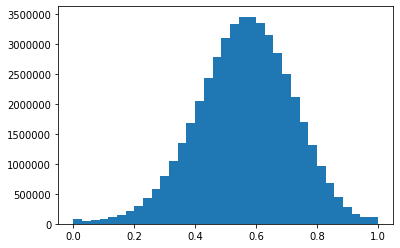

In [10]:
plt.hist(xtest3.flatten(),bins=35)

In [11]:
xtrain = df_train.pres_ano.values[:,:,:,None]
xtest  = df_test.pres_ano.values[:,:,:,None]
xtest2  = df_test2.pres_ano.values[:,:,:,None]
xtest3 = df_test3.pres_ano.values[:,:,:,None]

In [12]:
xtrain.shape,xtest.shape,y_train.shape,y_test.shape

((10839, 13, 90, 1), (1266, 13, 90, 1), (10839, 1), (1266, 1))

In [13]:
batch_size = 100
#num_classes = 10
epochs = 60
data_augmentation = True

In [14]:
import keras
#from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os


model = Sequential()
model.add(Conv2D(64*2, (2, 2), padding='same',
                 input_shape=xtrain.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64*2, (2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64*2, (2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64*2, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.25))

model.add(Conv2D(64*2, (2, 2), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64*2, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('linear'))

# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='mae',optimizer=opt)

Using TensorFlow backend.


In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 90, 128)       640       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 90, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 89, 128)       65664     
_________________________________________________________________
activation_2 (Activation)    (None, 12, 89, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 88, 128)       65664     
_________________________________________________________________
activation_3 (Activation)    (None, 11, 88, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 87, 128)      

In [16]:
xtrain1 = xtrain *1 #xtrain.astype('float32')
xtest1 = xtest *1 #xtest.astype('float32')
xtest2 = xtest2*1 #.astype('float32')

xtest3 = xtest3*1 #.astype('float32')

ytrain1 = train_y *1#y_train.values.astype('float32')
ytest1  = test_y *1 #y_test.values.astype('float32')
ytest2  = test_y2*1  #y_test2.values.astype('float32')

In [17]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(xtrain1, ytrain1,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(xtest1, ytest1),
              shuffle=False)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(xtrain1)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(xtrain1, ytrain1,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(xtest1, ytest1),
                        workers=4)

Using real-time data augmentation.
Epoch 1/60
109/109 [==============================] - 77s 702ms/step - loss: 0.1374 - val_loss: 0.1207
Epoch 2/60
109/109 [==============================] - 99s 912ms/step - loss: 0.1048 - val_loss: 0.1035
Epoch 3/60
109/109 [==============================] - 100s 920ms/step - loss: 0.0966 - val_loss: 0.0804
Epoch 4/60
109/109 [==============================] - 100s 917ms/step - loss: 0.0948 - val_loss: 0.0805
Epoch 5/60
109/109 [==============================] - 101s 924ms/step - loss: 0.0935 - val_loss: 0.0895
Epoch 6/60
109/109 [==============================] - 100s 919ms/step - loss: 0.0939 - val_loss: 0.0914
Epoch 7/60
109/109 [==============================] - 99s 908ms/step - loss: 0.0922 - val_loss: 0.0772
Epoch 8/60
109/109 [==============================] - 98s 902ms/step - loss: 0.0911 - val_loss: 0.0750
Epoch 9/60
109/109 [==============================] - 98s 897ms/step - loss: 0.0909 - val_loss: 0.0737
Epoch 10/60
109/109 [=============

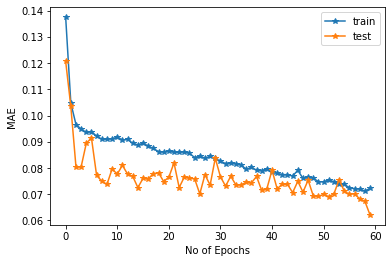

In [18]:
#model.history.keys()

plt.plot(model.history.history['loss'],'-*',label ='train')
plt.plot(model.history.history['val_loss'],'-*',label ='test')
plt.ylabel('MAE')
plt.xlabel('No of Epochs')
plt.legend()
# plt.savefig('RMM2_history.png')

## Correlation

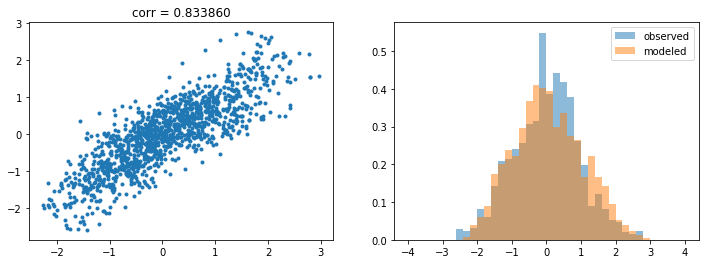

In [22]:
yy_test = model.predict(xtest)
yy_test = sc3.inverse_transform(yy_test)

test_corr = np.corrcoef(yy_test[:,0],y_test.values[:,0])[0,1]
yy_test   = yy_test[:,0]/yy_test[:,0].std()

# print("test shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_test,y_test.values[:,0],'.')

ax[0].set_title('corr = %f'%test_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_test.values[:,0],bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_test,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

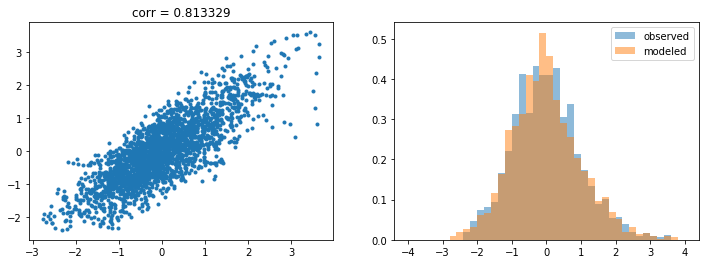

In [23]:
yy_test2 = model.predict(xtest2)
yy_test2 = sc3.inverse_transform(yy_test2)

test_corr2 = np.corrcoef(yy_test2[:,0],y_test2.values[:,0])[0,1]
yy_test2   = yy_test2[:,0]/yy_test2[:,0].std()

# print("test shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_test2,y_test2.values[:,0],'.')

ax[0].set_title('corr = %f'%test_corr2)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_test2.values[:,0],bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_test2,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

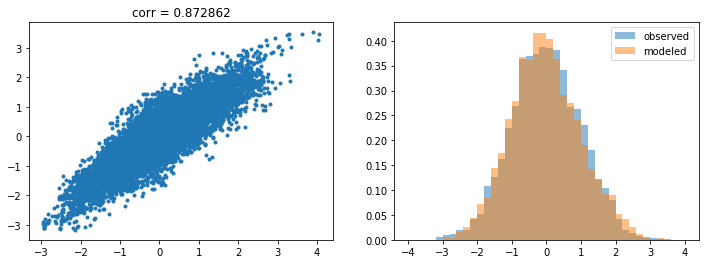

In [24]:
yy_train = model.predict(xtrain)
yy_train = sc3.inverse_transform(yy_train)

train_corr = np.corrcoef(yy_train[:,0],y_train.values[:,0])[0,1]
yy_train   = yy_train[:,0]/yy_train[:,0].std()

# print("train shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_train,y_train.values[:,0],'.')

ax[0].set_title('corr = %f'%train_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_train.values[:,0],bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_train,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

In [25]:
rmm2 = model.predict(xtest3)
rmm2   = sc3.inverse_transform(rmm2)

In [26]:
rmm2 = pd.DataFrame(rmm2,index=pd.to_datetime(df_test3.time[:].values),columns=['rmm2'])

(array([1.400e+01, 2.400e+01, 9.400e+01, 1.420e+02, 2.680e+02, 4.160e+02,
        7.090e+02, 1.106e+03, 1.477e+03, 2.170e+03, 2.565e+03, 2.951e+03,
        3.141e+03, 3.399e+03, 3.525e+03, 3.179e+03, 2.868e+03, 2.548e+03,
        2.216e+03, 1.798e+03, 1.514e+03, 1.257e+03, 9.380e+02, 7.680e+02,
        5.090e+02, 3.120e+02, 2.000e+02, 1.460e+02, 7.700e+01, 3.800e+01,
        2.600e+01, 1.300e+01, 8.000e+00, 2.000e+00, 4.000e+00]),
 array([-2.4653902 , -2.2983773 , -2.1313646 , -1.9643517 , -1.7973388 ,
        -1.6303259 , -1.4633131 , -1.2963002 , -1.1292874 , -0.9622745 ,
        -0.7952617 , -0.6282488 , -0.46123594, -0.2942231 , -0.12721023,
         0.03980262,  0.20681548,  0.37382832,  0.54084116,  0.70785403,
         0.8748669 ,  1.0418798 ,  1.2088926 ,  1.3759055 ,  1.5429183 ,
         1.7099311 ,  1.8769441 ,  2.043957  ,  2.2109697 ,  2.3779826 ,
         2.5449955 ,  2.7120082 ,  2.8790212 ,  3.046034  ,  3.2130468 ,
         3.3800597 ], dtype=float32),
 <a list of 35 P

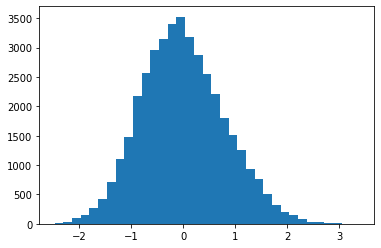

In [27]:
plt.hist(rmm2.rmm2,bins=35)

In [28]:
rmm2.to_csv('test_rmm2.csv')

In [ ]:
plt.plot(rmm2.rmm2)
plt.axhline(3)
plt.axhline(-3)

In [ ]:
# model.save("deep_CNN_rmm2_minmaxscalar_batchsize_100_woymnmx.h5")
# print("Saved model to disk")

In [ ]:
rmm2